# CNN new

In [44]:
import matplotlib.pyplot as plt
import skimage.io as io
from PIL import Image
import numpy as np
import torch
from torch import nn
from torchvision import datasets, transforms
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
import torch.nn as nn

In [72]:
train_dir = './data/train'
test_dir = './data/test'

trainTransform  = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                    transforms.ToTensor()])

# trainset = datasets.ImageFolder(train_dir,trainTransform)
# testset = datasets.ImageFolder(test_dir,trainTransform)
train = datasets.ImageFolder(train_dir,trainTransform)
test = datasets.ImageFolder(test_dir,trainTransform)
# Define the size of the dataset and split
total_train = len(train)
val_size = int(0.2 * total_train)
train_size = total_train - val_size
trainset, validset = random_split(train, [train_size, val_size])

In [73]:
train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(validset, batch_size=64, shuffle=True)

In [74]:
class CNN(nn.Module):
    def __init__(self,):
        super(CNN,self).__init__()
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Dropout2d(p=0.25)
        )
        
        self.linear = nn.Sequential(
            nn.Linear(247808, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 7)
        )
    def forward(self,x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x

In [75]:
# Instantiate the model
model = CNN()

# Define loss function and optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [77]:
epochs = 5

train_loss = []
valid_loss = []

for epoch in range(epochs):
    model.train()
    epoch_train_loss = 0    
    for images, labels in train_loader:
        optimizer.zero_grad()
        output = model(images)
        # print("Output:", output," labels::", labels) 
        loss = loss_func(output, labels)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    train_loss.append(epoch_train_loss/len(train_loader))
    
    model.eval()   
    epoch_valid_loss = 0
    for images, labels in valid_loader:
        output = model(images)
        # print("Output:", output," labels::", labels) 
        loss = loss_func(output, labels)
        epoch_valid_loss += loss.item()
    valid_loss.append(epoch_valid_loss / len(valid_loader))
    
    print(f"Epoch: {epoch} Train loss: {train_loss[-1]} Valid loss: {valid_loss[-1]}")

Epoch: 0 Train loss: 1.6201694499815407 Valid loss: 1.619825839996338
Epoch: 1 Train loss: 1.5431581835228754 Valid loss: 1.5531502617730035
Epoch: 2 Train loss: 1.490745831332831 Valid loss: 1.4712987290488349
Epoch: 3 Train loss: 1.4436698833215869 Valid loss: 1.4318785217073229
Epoch: 4 Train loss: 1.3954918829511467 Valid loss: 1.4192905399534437


In [83]:
def validate_model(model, val_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            # images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

In [84]:
validation_accuracy = validate_model(model, valid_loader)

In [86]:
validation_accuracy

42.49390456287008

In [90]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10):
    model.train()
    training_stats = []
    
    for epoch in range(num_epochs):
        total_train_loss = 0
        total_val_loss = 0
        total_val_accuracy = 0
        
        # Training phase
        for batch_index, (images, labels) in enumerate(train_loader):
            # images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

            # Each batch
            if (batch_index + 1) % 10 == 0:
                print(f"Epoch {epoch+1}, Batch {batch_index+1}: Train Loss so far: {total_train_loss / (batch_index + 1)}")

        # Validation phase
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for batch_index, (images, labels) in enumerate(val_loader):
                # images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                total_val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                # Validation update for each batch
                if (batch_index + 1) % 10 == 0:
                    print(f"Epoch {epoch+1}, Validation Batch {batch_index+1}: Validation Loss so far: {total_val_loss / (batch_index + 1)}")

            accuracy = 100 * correct / total
            total_val_accuracy = accuracy

        # Store statistics
        training_stats.append({
            'train_loss': total_train_loss / len(train_loader),
            'val_loss': total_val_loss / len(val_loader),
            'val_accuracy': total_val_accuracy
        })
        
        print(f"Epoch {epoch+1}: Train Loss: {total_train_loss / len(train_loader)}, Val Loss: {total_val_loss / len(val_loader)}, Val Accuracy: {total_val_accuracy}%")
    
    return training_stats

# Call the training function
training_stats = train_model(model, loss_func, optimizer, train_loader, valid_loader)

Epoch 1, Batch 10: Train Loss so far: 1.3541157603263856
Epoch 1, Batch 20: Train Loss so far: 1.401525580883026
Epoch 1, Batch 30: Train Loss so far: 1.3945023934046428
Epoch 1, Batch 40: Train Loss so far: 1.4083321064710617
Epoch 1, Batch 50: Train Loss so far: 1.4142794132232666
Epoch 1, Batch 60: Train Loss so far: 1.409815106789271
Epoch 1, Batch 70: Train Loss so far: 1.4072866950716292
Epoch 1, Batch 80: Train Loss so far: 1.4090562894940377
Epoch 1, Batch 90: Train Loss so far: 1.411641702387068
Epoch 1, Batch 100: Train Loss so far: 1.4134789991378784
Epoch 1, Batch 110: Train Loss so far: 1.4092735713178461
Epoch 1, Batch 120: Train Loss so far: 1.4082354267438253
Epoch 1, Batch 130: Train Loss so far: 1.4109726905822755
Epoch 1, Batch 140: Train Loss so far: 1.4149789988994599
Epoch 1, Batch 150: Train Loss so far: 1.4109139084815978
Epoch 1, Batch 160: Train Loss so far: 1.4085259184241294
Epoch 1, Batch 170: Train Loss so far: 1.406374601055594
Epoch 1, Batch 180: Train L

In [91]:
def validate_model(model, val_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            # images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

In [92]:
validation_accuracy = validate_model(model, valid_loader)

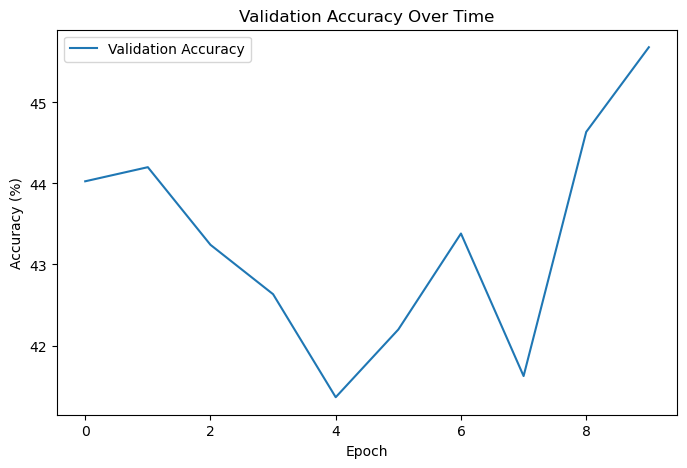

In [93]:
# Plot accuracy or other metrics as needed
plt.figure(figsize=(8, 5))
plt.title('Validation Accuracy Over Time')
plt.plot([x['val_accuracy'] for x in training_stats], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

In [95]:
import torch

def test_model_detailed(model, test_loader, num_classes):
    model.eval()  # Set the model to evaluation mode
    correct_count = [0] * num_classes
    total_count = [0] * num_classes
    total_correct = 0
    total_samples = 0

    with torch.no_grad():  # Turn off gradients for validation, saves memory and computations
        for images, labels in test_loader:
            # images = images.to(device)
            # labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct_predictions = (predicted == labels)

            # Update per-class statistics
            for label, prediction in zip(labels, predicted):
                total_count[label] += 1
                if label == prediction:
                    correct_count[label] += 1
            
            # Update total statistics
            total_correct += correct_predictions.sum().item()
            total_samples += labels.size(0)
    
    overall_accuracy = 100 * total_correct / total_samples
    print(f'Test Accuracy: {overall_accuracy:.2f}%')

    return correct_count, total_count, overall_accuracy
    
correct_count, total_count, overall_accuracy = test_model_detailed(model, test_loader, num_classes=len(emotions))
incorrect_count = [total_count[i] - correct_count[i] for i in range(len(total_count))]

Test Accuracy: 49.13%


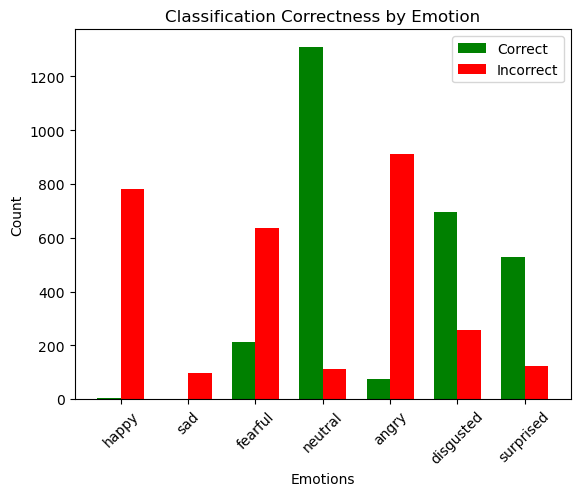

In [96]:
# Define the emotions labels
emotions = ['happy', 'sad', 'fearful', 'neutral', 'angry', 'disgusted', 'surprised']

# Define the width of the bars
bar_width = 0.35

# Define the x-axis positions for the bars
x = range(len(emotions))

# Plotting the bars for correct counts
plt.bar(x, correct_count, width=bar_width, label='Correct', color='green')

# Plotting the bars for incorrect counts
plt.bar([i + bar_width for i in x], incorrect_count, width=bar_width, label='Incorrect', color='red')

# Adding labels, title, and custom x-axis tick labels
plt.xlabel('Emotions')
plt.ylabel('Count')
plt.title('Classification Correctness by Emotion')
plt.xticks([i + bar_width / 2 for i in x], emotions, rotation=45)
plt.legend()

# Display the plot
plt.show()